# Linear Regression Implementation from Scratch

We will implement the entire method from scratch,
including the data pipeline, the model,
the loss function, and the minibatch stochastic gradient descent optimizer

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

Construct an artificial dataset
according to a linear model with additive noise.
The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and
$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

In [3]:
def synthetic_data(w, b, num_examples):  
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Each row in `features` consists of a 2-dimensional data example
and that each row in `labels` consists of a 1-dimensional label value (a scalar)

In [4]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([1.0230, 0.3393]) 
label: tensor([5.0887])


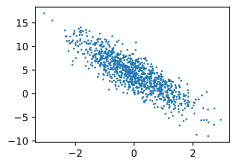

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1);

Define the `data_iter` function
that
takes a batch size, a matrix of features,
and a vector of labels, yielding minibatches of the size `batch_size`

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.4760, -1.0733],
        [-0.3200,  0.4213],
        [ 0.5622, -0.0568],
        [ 0.9808,  0.0396],
        [-1.7828,  1.7792],
        [ 1.8517, -1.6391],
        [-1.2349, -0.9307],
        [-0.8085, -2.0467],
        [-0.9074,  0.5514],
        [-1.3967, -1.5799]]) 
 tensor([[10.7932],
        [ 2.1343],
        [ 5.5225],
        [ 6.0263],
        [-5.4184],
        [13.4798],
        [ 4.8955],
        [ 9.5438],
        [ 0.5139],
        [ 6.7874]])


Before we can begin optimizing our model's parameters
we need to have some parameters in the first place

In [8]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

Define our model,
relating its inputs and parameters to its outputs

In [9]:
def linreg(X, w, b):  
    """The linear regression model."""
    return torch.matmul(X, w) + b

Updating our model requires taking
the gradient of our loss function,
define the loss function first

In [10]:
def squared_loss(y_hat, y):  
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

Despite linear regression has a closed-form solution, other models in this book don't. Here we introduce minibatch stochastic gradient descent

In [11]:
def sgd(params, lr, batch_size):  
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

Implement the main training loop

In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.038001
epoch 2, loss 0.000138
epoch 3, loss 0.000051


Evaluate our success in training
by comparing the true parameters
with those that we learned

In [14]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([ 8.7547e-04, -2.1219e-05], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0003], grad_fn=<RsubBackward1>)
